In [2]:
import logging
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

First of all, let's load the dataset and filter it so that we can get only those orders which have 5 or more products on it:


In [3]:
data=pd.read_csv("feature_frames.csv")
filtered_data = data[data['user_order_seq'] > 5]
#print(filtered_data.head())
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Las primeras filas del DataFrame son:\n%s", filtered_data.head().to_string())


2024-02-04 19:04:35,200 - INFO - Las primeras filas del DataFrame son:
        variant_id     product_type       order_id        user_id           created_at           order_date  user_order_seq  outcome  ordered_before  abandoned_before  active_snoozed  set_as_regular  normalised_price  discount_pct       vendor  global_popularity  count_adults  count_children  count_babies  count_pets  people_ex_baby  days_since_purchase_variant_id  avg_days_to_buy_variant_id  std_days_to_buy_variant_id  days_since_purchase_product_type  avg_days_to_buy_product_type  std_days_to_buy_product_type
7   33826472919172  ricepastapulses  2808549900420  3437017956484  2020-10-06 14:24:26  2020-10-06 00:00:00              13      0.0             0.0               0.0             0.0             0.0          0.081052      0.053512  clearspring           0.038462           2.0             0.0           0.0         0.0             2.0                            33.0                        42.0                  

LINEAL MODELS

for the POC, we will start analysing some linear models.

Before doing so, let's check which variables may be more influent on the decision of making an order. Instead of doing it by intuition, let's check with the correlation matrix. The purpose of this is reducing overfitting.

                                  variant_id  order_id   user_id  \
variant_id                          1.000000  0.092340  0.055808   
order_id                            0.092340  1.000000  0.244780   
user_id                             0.055808  0.244780  1.000000   
user_order_seq                      0.001654  0.012672 -0.395196   
outcome                             0.023811 -0.002848 -0.018644   
ordered_before                     -0.050871 -0.018179 -0.047676   
abandoned_before                   -0.000225 -0.007747 -0.005435   
active_snoozed                     -0.090176 -0.028793 -0.084046   
set_as_regular                     -0.005723  0.028609  0.013799   
normalised_price                   -0.013617  0.017779  0.008473   
discount_pct                       -0.112025 -0.011877 -0.006636   
global_popularity                   0.082147 -0.035902 -0.029731   
count_adults                        0.011750  0.062565  0.026388   
count_children                     -0.013571 -0.

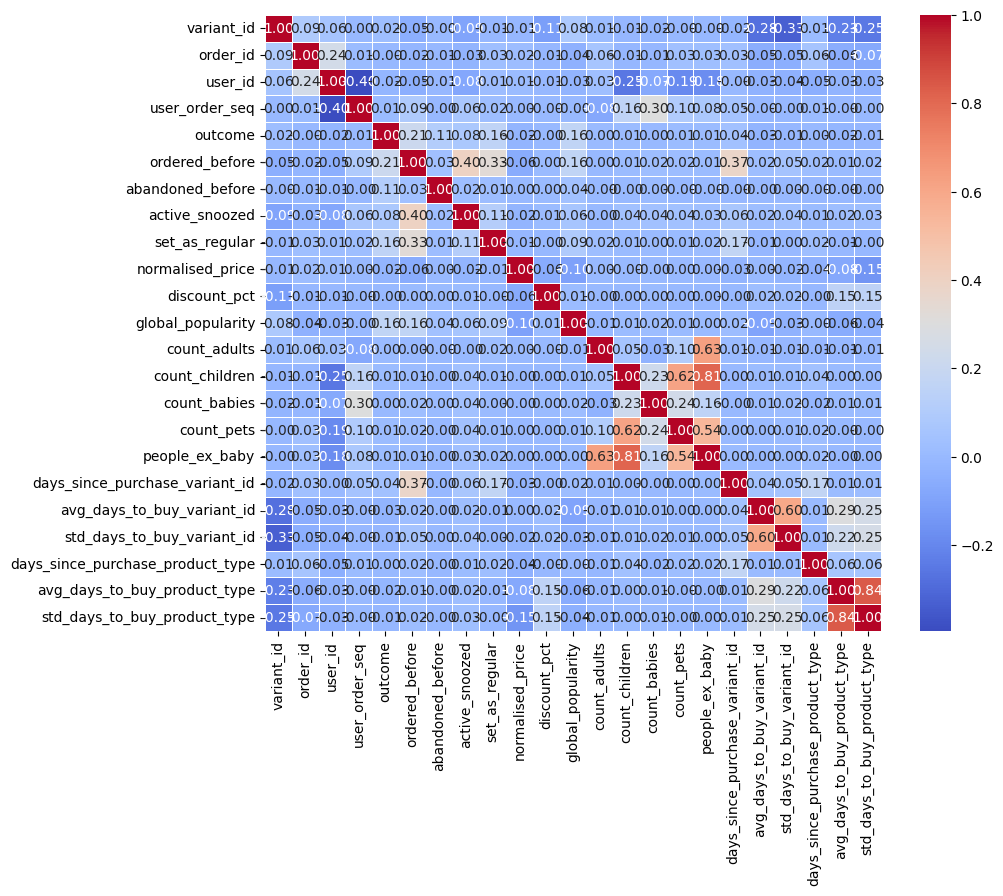

In [4]:
df = pd.DataFrame(filtered_data)
df_numeric = df.select_dtypes(include=[np.number])
correlation_matrix = df_numeric.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))  # Puedes ajustar el tamaño a tus necesidades
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            cbar=True, square=True, linewidths=.5)

# Mostrar el gráfico
plt.show()


So my predictible variable will be "outcome", which will represent the probability of a user buying a determined product when a notification shows up.

For doing so, I`m first going to divide de dataset into X and y. I will for this purpose consider not relevant many columns such as the order_id for example. Nevertheless, I will include some details such as the day of the week that the order was made, the hour, or the year station.

In [5]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['order_date'] = pd.to_datetime(df['order_date'])

def get_season(month):
    if month in [12, 1, 2]:
        return 1  # Invierno
    elif month in [3, 4, 5]:
        return 2  # Primavera
    elif month in [6, 7, 8]:
        return 3  # Verano
    else:
        return 4  # Otoño


df['season'] = df['order_date'].dt.month.apply(get_season)

df['day_of_week'] = df['order_date'].dt.dayofweek
df['is_weekend'] = df['order_date'].dt.dayofweek >= 5
df['hour_of_day'] = df['order_date'].dt.hour

X = df.drop(['variant_id', 'order_id', 'user_id', 'created_at', 'order_date', 'outcome'], axis=1)
X = pd.concat([X, df[['day_of_week', 'is_weekend', 'hour_of_day']]], axis=1)
y = df['outcome']

logging.info("Las primeras filas de X son:\n%s", X.head().to_string())


2024-02-04 19:04:38,485 - INFO - Las primeras filas de X son:
       product_type  user_order_seq  ordered_before  abandoned_before  active_snoozed  set_as_regular  normalised_price  discount_pct       vendor  global_popularity  count_adults  count_children  count_babies  count_pets  people_ex_baby  days_since_purchase_variant_id  avg_days_to_buy_variant_id  std_days_to_buy_variant_id  days_since_purchase_product_type  avg_days_to_buy_product_type  std_days_to_buy_product_type  season  day_of_week  is_weekend  hour_of_day  day_of_week  is_weekend  hour_of_day
7   ricepastapulses              13             0.0               0.0             0.0             0.0          0.081052      0.053512  clearspring           0.038462           2.0             0.0           0.0         0.0             2.0                            33.0                        42.0                   31.134053                              30.0                          30.0                      24.27618       4       

Now that we have divided our X & y ; let's try to select among the variables we have, which ones are the most importants. For this purpose, I will use the Random Forest Classifier.

2024-02-04 19:05:40,899 - INFO - Los resultados de nuestro modelo son:
global_popularity                          1.833608e-01
days_since_purchase_product_type           1.104881e-01
user_order_seq                             1.031106e-01
days_since_purchase_variant_id             5.636556e-02
day_of_week                                4.611287e-02
day_of_week                                4.543554e-02
std_days_to_buy_variant_id                 4.298277e-02
avg_days_to_buy_variant_id                 3.803877e-02
ordered_before                             3.457200e-02
discount_pct                               3.293602e-02
normalised_price                           2.986413e-02
count_pets                                 2.242627e-02
season                                     1.861620e-02
set_as_regular                             1.742800e-02
people_ex_baby                             1.570393e-02
std_days_to_buy_product_type               1.503845e-02
count_children                   

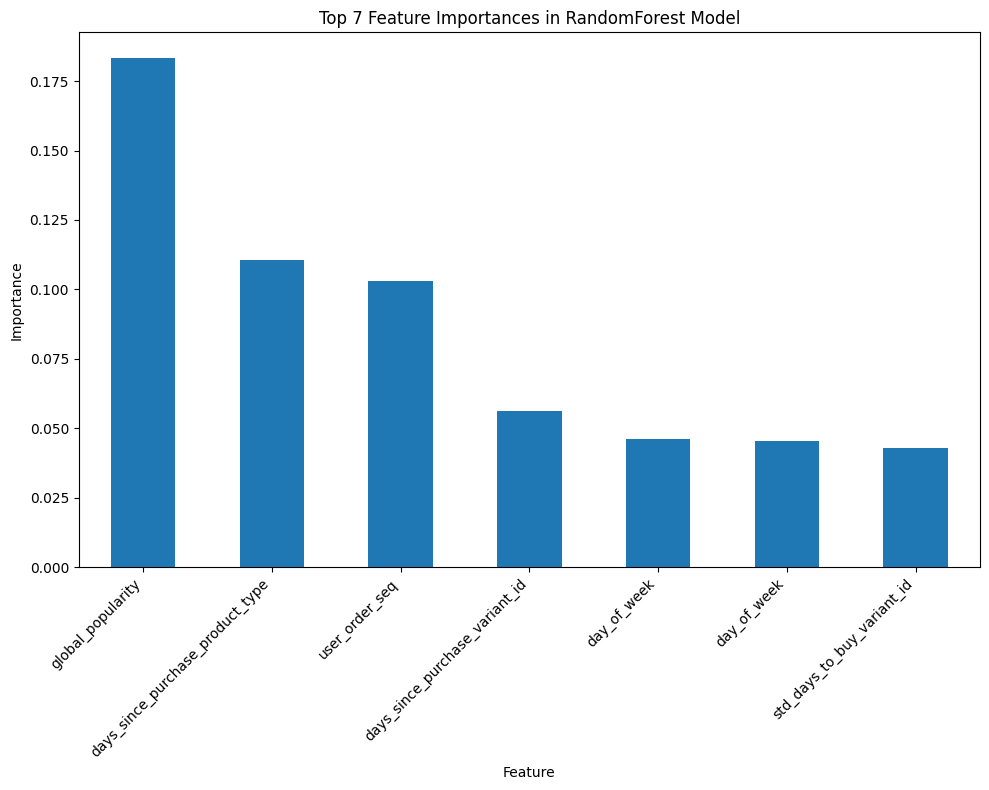

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_encoded = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)

importances = model.feature_importances_

feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

logging.info("Los resultados de nuestro modelo son:\n%s", feature_importances.to_string())


# Graph of importances
top_features = feature_importances[:7]

# Gráfico de barras para las 7 características más importantes
plt.figure(figsize=(10, 8))
top_features.plot(kind='bar')
plt.title('Top 7 Feature Importances in RandomForest Model')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Ajusta la disposición para evitar la superposición de etiquetas
plt.show()

Based on the result of our model; we had obtained several conclutions:

"Global_popularity" is the most significant feature in your model with an importance of approximately 0.1837, indicating it greatly influences user interest predictions. "Days_since_purchase_product_type" and "user_order_seq" also matter, with importances around 0.1113 and 0.1029, showing they're key but less so than global popularity.

"Days_since_purchase_variant_id" and "day_of_week" have lower importances (about 0.0578 and 0.0447), suggesting their minor yet present impact on predictions. Features with minimal or zero importance, like vendor names and "hour_of_day" (notably listed twice with zero importance), appear to have little to no impact, hinting at potential data processing errors or interpretation issues.

Therefore, we are going to remove them.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train_reduced = X_train.drop(['vendor_munchkin', 'vendor_vicks', 'hour_of_day'], axis=1)
X_test_reduced = X_test.drop(['vendor_munchkin', 'vendor_vicks', 'hour_of_day'], axis=1)

NOW, LET'S START WITH LOGISTIC REGRESSION:




In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#first we standarize
scaler = StandardScaler()
X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

model_lr = LogisticRegression(max_iter=1000)  
model_lr.fit(X_train_reduced_scaled, y_train)

#evaluating the model
y_pred = model_lr.predict(X_test_reduced_scaled)
accuracy = accuracy_score(y_test, y_pred)
logging.info("Accuracy of the Logistic Regression model: %s", accuracy)

#with more detail
report = classification_report(y_test, y_pred)
logging.info("Classification report:\n%s", report)


2024-02-04 19:06:05,541 - INFO - Accuracy of the Logistic Regression model: 0.9862261266860397
2024-02-04 19:06:05,735 - INFO - Classification report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     58698
         1.0       0.69      0.03      0.06       835

    accuracy                           0.99     59533
   macro avg       0.84      0.52      0.53     59533
weighted avg       0.98      0.99      0.98     59533



NOW, LET'S DO A PCA SO THAT WE CAN REDUCE IT TO A TWO PRINCIPAL COMPONENTS FOR VISUALITATION. THAT WAY, IT WOULD BE EASIER TO UNDERSTAND THE RESULTS OF THE LOGISTIC REGRESSION:

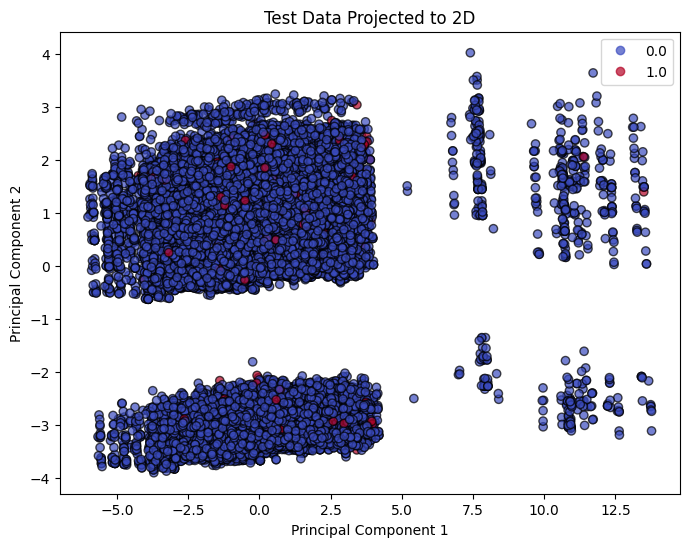

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=2)  
X_test_reduced_2D = pca.fit_transform(X_test_reduced_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_test_reduced_2D[:, 0], X_test_reduced_2D[:, 1], c=y_test, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.title('Test Data Projected to 2D')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=set(y_test))
plt.show()


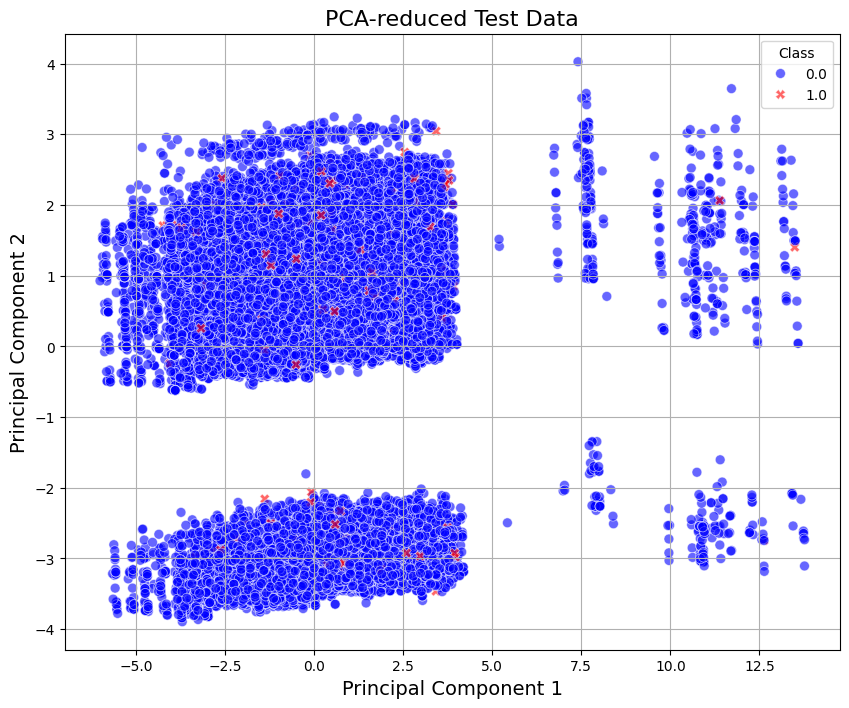

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_test_reduced_2D and y_test are already defined

# Increase the figure size for better visibility
plt.figure(figsize=(10, 8))

# Plot with increased transparency (alpha) and smaller marker size (s)
sns.scatterplot(x=X_test_reduced_2D[:, 0], y=X_test_reduced_2D[:, 1], hue=y_test,
                style=y_test, alpha=0.6, s=50, palette=['blue', 'red'])

# Add grid for better readability
plt.grid(True)

# Adding titles and labels
plt.title('PCA-reduced Test Data', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)

# Add a legend
plt.legend(title='Class', loc='best')

# Show the plot
plt.show()


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Assuming X_train_reduced, X_test_reduced, y_train, and y_test are defined elsewhere

# First, we standardize
scaler = StandardScaler()
X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

model_lr = LogisticRegression(max_iter=1000)  
model_lr.fit(X_train_reduced_scaled, y_train)

# Evaluating the model
y_pred = model_lr.predict(X_test_reduced_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the Logistic Regression model:", accuracy)

# With more detail
report = classification_report(y_test, y_pred)
print("Classification report:\n", report)

# Visualizing the decision boundary
x_min, x_max = X_test_reduced_scaled[:, 0].min() - 1, X_test_reduced_scaled[:, 0].max() + 1
y_min, y_max = X_test_reduced_scaled[:, 1].min() - 1, X_test_reduced_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = model_lr.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_test_reduced_scaled[:, 0], X_test_reduced_scaled[:, 1], c=y_test, s=20, edgecolor='k')
plt.title('Logistic Regression Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


Accuracy of the Logistic Regression model: 0.9862261266860397
Classification report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     58698
         1.0       0.69      0.03      0.06       835

    accuracy                           0.99     59533
   macro avg       0.84      0.52      0.53     59533
weighted avg       0.98      0.99      0.98     59533



ValueError: X has 2 features, but LogisticRegression is expecting 348 features as input.

The Logistic Regression model achieves 98.62% accuracy, indicating high overall performance. However, it excels at identifying the majority class (0.0) with nearly 99% precision and 100% recall but struggles with the minority class (1.0), showing only 69% precision and a mere 3% recall. This discrepancy suggests difficulties in detecting the less frequent class, likely due to class imbalance. Macro averages reveal the challenge with a lower performance on the minority class.

For this purpose, I am just going to redo the logistic regression as follows, with the aim of assigning weights inversely proportional to class frequencies. This ensures less frequent classes gain higher importance during training, enhancing model performance on these classes.



In [9]:
model_lr = LogisticRegression(max_iter=1000, class_weight='balanced')
model_lr.fit(X_train_reduced_scaled, y_train)
#evaluating the model
y_pred = model_lr.predict(X_test_reduced_scaled)
accuracy = accuracy_score(y_test, y_pred)
logging.info("Accuracy of the Logistic Regression model: %s", accuracy)

#with more detail
report = classification_report(y_test, y_pred)
logging.info("Classification report:\n%s", report)


2024-02-04 19:06:23,572 - INFO - Accuracy of the Logistic Regression model: 0.8398535266154906
2024-02-04 19:06:23,790 - INFO - Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     58698
         1.0       0.06      0.66      0.10       835

    accuracy                           0.84     59533
   macro avg       0.53      0.75      0.51     59533
weighted avg       0.98      0.84      0.90     59533



The use of class_weight='balanced' likely improved recall for the minority class at the cost of precision, demonstrating the trade-off between detecting minority class instances and maintaining accuracy in predictions.

LET'S NOW PROCEED WITH RIDGE REGRESSION:

we know that by adding a degree of bias to the regression estimates, ridge regression reduces the standard errors. It is used to analyze data that suffers from multicollinearity (independent variables are highly correlated). In multicollinearity, even though the least squares estimates (OLS) are unbiased, their variances can be large, and they may be far from the true value. Ridge regression improves the prediction accuracy by shrinking the regression coefficients to avoid overfitting but introduces some bias into the estimates. This trade-off between reducing variance and introducing bias makes ridge regression particularly useful when dealing with ill-posed problems or when preventing overfitting

In [10]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score

#define the alpha values:
alpha_values = np.logspace(-4, 4, 100)  # From 10^-4 to 10^4
ridge_cv = RidgeCV(alphas=alpha_values, store_cv_values=True)
ridge_cv.fit(X_train_reduced_scaled, y_train)

#best alpha
best_alpha = ridge_cv.alpha_
logging.info("Best alpha is: %s", best_alpha)

# Evaluate the model
y_pred = ridge_cv.predict(X_test_reduced_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

logging.info("mse is: %s", mse)
logging.info("r2 is: %s", r2)


2024-02-04 19:07:41,977 - INFO - Best alpha is: 3944.2060594376644
2024-02-04 19:07:42,132 - INFO - mse is: 0.012805466801399452
2024-02-04 19:07:42,133 - INFO - r2 is: 0.07402092764411194


As we can see with the different measures, the best alpha is 3944.2. With this value of alpha (done with cross validation), we can create a very good ridge regression, since the value of the mse is very small, 0.0128, and the value of the r2 of 0,074. An R² value of 0.074 suggests the model poorly explains the variance in the target, likely due to its simplicity, irrelevant features, poor data quality, or high bias from strong regularization (alpha=3944.206). This strong regularization helps prevent overfitting but may cause underfitting, failing to capture key data patterns. So as a conclution, since the variance explained is very small, we wouldn't proceed with this model.

LASSO REGRESSION:

Lasso Regression is a type of linear regression that uses shrinkage. Shrinkage is where data values are shrunk towards a central point, like the mean. The lasso procedure encourages simple, sparse models (i.e., models with fewer parameters). This particular type of regression is well-suited for models showing high levels of multicollinearity or when you want to automate certain parts of model selection, like variable selection/parameter elimination.

My initial guess is that Lasso will work better since we have many features and therefore this model will force many of these to zero.

In [11]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score

#range of alpha
alphas = np.logspace(-6, -1, 100)

lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(X_train_reduced_scaled, y_train)

logging.info("Best alpha is: %s", lasso_cv.alpha_)

y_pred = lasso_cv.predict(X_test_reduced_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

logging.info("mse is: %s", mse)
logging.info("r2 is: %s", r2)

2024-02-04 19:09:53,688 - INFO - Best alpha is: 0.000298364724028334
2024-02-04 19:09:53,737 - INFO - mse is: 0.012804175865099155
2024-02-04 19:09:53,748 - INFO - r2 is: 0.07411427683757432


The optimal alpha values found for Lasso and Ridge indicate the degree of regularization that best fits the data. A relatively small alpha for Lasso, 0.000298, suggests minimal regularization, which might not lead to significant feature elimination or coefficient shrinking, making Lasso's outcome closer to Ridge's, where features are not eliminated but their influence is moderated. This happens due to the multicollinearity of the dataset, which prevents no big difference between Lasso's feature selection capability and Ridge's coefficient shrinkage.
It also may be due to the fact that almost all of the predictors may have very similar contributions to the outcome, as we could check with the random forest graph.

LET'S TRY SOME OTHER LINEAR MODELS. I'M GOING TO DIRECTLY AVOID USING LINEAR REGRESSION SINCE THE OUTPUT I WANT TO VERIFY IS NOT CONTINUOUS. BUT I'M GOING TO DO THE FOLLOWING LINEAR MODELS: ELASTIC NET REGRESSION, LDA, SVM WITH LINEAR KERNEL, STOCHASTIC GRADIENT DESCENT & GENERALIZED LINEAR MODELS. AFTER DOING SO, I AM GOING TO EVALUATE THE BEST MODEL FOR OUR GOAL USING EXPERIMENTATION OR CROSS VALIDATION.

UP TO NOW, OPTING FOR LINEAR REGRESSION OVER LASSO HINGES ON VALUING SIMPLICITY AND CLEAR INTERPRETABILITY. LINEAR REGRESSION'S DIRECT COEFFICIENT INTERPRETATION OFFERS INSIGHTS INTO HOW PREDICTORS IMPACT THE OUTCOME, IDEAL WHEN ALL VARIABLES ARE RELEVANT AND THE GOAL IS TO UNDERSTAND THEIR INFLUENCE WITHOUT THE COMPLEXITY OF LASSO'S REGULARIZATION. THIS APPROACH IS PREFERABLE IN LOW-DIMENSIONAL DATA WHERE MODEL TRANSPARENCY AND EASE OF EXPLANATION TO STAKEHOLDERS ARE KEY, MAKING IT A STRAIGHTFORWARD CHOICE FOR PROJECTS EMPHASIZING THE ELUCIDATION OF PREDICTOR EFFECTS.

THIS IS WHY LINEAR REGRESSION IS THE BEST APPROACH UP TO THIS POINT. WILL IT STILL BE AFTER TRYING WITH ALL THESE DIFFERENT MODELS?



ELASTIC NET REGRESSION: Combines L1 and L2 regularization (from Lasso and Ridge) into one model. It's Useful when you have a large number of correlated predictors.

In [12]:
from sklearn.linear_model import ElasticNetCV
alphas = np.logspace(-4, 4, 100)

# l1_ratio values: 0 is Ridge, 1 is Lasso. 
l1_ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]

# Initialize the ElasticNetCV model
elastic_net_cv = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratio, cv=5, random_state=42, max_iter=10000)

elastic_net_cv.fit(X_train_reduced_scaled, y_train)
print("Best alpha:", elastic_net_cv.alpha_)
print("Best l1_ratio:", elastic_net_cv.l1_ratio_)

y_pred = elastic_net_cv.predict(X_test_reduced_scaled)
adjusted_mse = mean_squared_error(y_test, y_pred)
adjusted_r2 = r2_score(y_test, y_pred)

print("Adjusted Mean Squared Error:", adjusted_mse)
print("Adjusted R-squared:", adjusted_r2)


Best alpha: 0.0003053855508833415
Best l1_ratio: 1.0
Adjusted Mean Squared Error: 0.012804329673793993
Adjusted R-squared: 0.07410315474145901


The MSE and R-squared values for Elastic Net are very similar to those reported for both Lasso and Ridge. This similarity, especially given that the l1_ratio is 1.0, indicates that your dataset might benefit more from L1 regularization (like Lasso) 

LET'S NOW GO WITH LDA

In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_reduced_scaled, y_train)
y_pred_lda = lda.predict(X_test_reduced_scaled)
# Calculate accuracy
accuracy_lda = accuracy_score(y_test, y_pred_lda)
print("Accuracy:", accuracy_lda)

# Generate a classification report
print(classification_report(y_test, y_pred_lda))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_lda)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.971293232324929
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     58698
         1.0       0.18      0.30      0.23       835

    accuracy                           0.97     59533
   macro avg       0.59      0.64      0.61     59533
weighted avg       0.98      0.97      0.97     59533

Confusion Matrix:
 [[57575  1123]
 [  586   249]]


The LDA model achieved an impressive overall accuracy of 97.13%, indicating high effectiveness in classifying the dataset. While it excellently identified the majority class (0.0) with high precision and recall, its performance on the minority class (1.0) was less effective, with relatively low precision (0.18) but a moderate recall (0.30). The F1-score for the minority class (0.23) suggests room for improvement in balancing precision and recall. The confusion matrix reveals the model correctly classified a significant portion of the majority class but also had a notable number of false positives (1123) and false negatives (586), indicating challenges in accurately predicting the minority class

In [15]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

svm_linear = LinearSVC(random_state=42, max_iter=10000)  # Aumenta max_iter si es necesario
svm_linear.fit(X_train_reduced_scaled, y_train)
y_pred_svm = svm_linear.predict(X_test_reduced_scaled)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy_svm)

print(classification_report(y_test, y_pred_svm))

conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:\n", conf_matrix_svm)



/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-_MSORb09-py3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-_MSORb09-py3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.9862093292795593
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     58698
         1.0       0.89      0.02      0.04       835

    accuracy                           0.99     59533
   macro avg       0.94      0.51      0.52     59533
weighted avg       0.98      0.99      0.98     59533

Confusion Matrix:
 [[58696     2]
 [  819    16]]


The model boasts a high accuracy of 98.62%, excelling at identifying the majority class (0.0) with near-perfect precision and recall. However, it struggles significantly with the minority class (1.0), evidenced by high precision but abysmally low recall, leading to a poor F1-score for this class. This discrepancy reveals a model highly effective at predicting common outcomes but nearly incapable of recognizing rare events, a typical challenge in imbalanced datasets. The confusion matrix starkly illustrates this bias, with the model correctly predicting the majority class instances while failing to detect the majority of the minority class. Despite the overall accuracy, the model's utility is limited by its inability to adequately capture the nuances of the less represented class, necessitating strategies aimed at improving its sensitivity to these critical but infrequent cases.

NOW STOCHASTIC GRADIENT DESCENT

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Inicializa SGDClassifier con 'log_loss' para la regresión logística
sgd_clf = SGDClassifier(loss='log_loss', random_state=42, max_iter=1000, tol=1e-3)

# Ajusta el modelo
sgd_clf.fit(X_train_reduced_scaled, y_train)

# Realiza predicciones
y_pred_sgd = sgd_clf.predict(X_test_reduced_scaled)

# Evalúa el modelo
accuracy_sgd = accuracy_score(y_test, y_pred_sgd)
print("Accuracy:", accuracy_sgd)
print(classification_report(y_test, y_pred_sgd))
conf_matrix_sgd = confusion_matrix(y_test, y_pred_sgd)
print("Confusion Matrix:\n", conf_matrix_sgd)



Accuracy: 0.9841936405019065
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     58698
         1.0       0.31      0.10      0.15       835

    accuracy                           0.98     59533
   macro avg       0.65      0.55      0.57     59533
weighted avg       0.98      0.98      0.98     59533

Confusion Matrix:
 [[58506   192]
 [  749    86]]


The SGD Classifier achieved an overall accuracy of 98.42%, demonstrating strong effectiveness in classifying the dataset, particularly for the majority class (0.0) with almost perfect precision and recall. However, its performance on the minority class (1.0) is weaker, with low precision and even lower recall, indicating challenges in accurately identifying responsive users. The low F1-score for this class highlights a poor balance between precision and recall, further evidenced by a significant number of false negatives (749) in the confusion matrix. This disparity suggests that while highly effective for non-responsive users, the model's ability to pinpoint responsive individuals needs refinement.